<h1>
<hr style=" border:none; height:3px;">
<center>Computer Vision - Photo to Chess Board Project</center>
<hr style=" border:none; height:3px;">
</h1>

<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h4><center>Louis LHOTTE | Paul-Alexandre MARENGHI</center></h4>

# 0 - Import

https://github.com/shainisan/real-life-chess-vision
<div class='alert alert-block alert-success'> <strong>PLAN</strong> <br>
- Read Img<br>
- Detect Corners<br>
- Perspective Transformation + calculate square positions<br>
- Detect pieces on board<br>
- TADA!<br>
</div>


In [3]:
from matplotlib.pyplot import figure
import matplotlib.image as image
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
from PIL import Image
import cv2
from shapely.geometry import Polygon, box

# I - Detect Corners

## I.1 - Detection of corner

In [32]:
def segment_chessboard(image_path):
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # You might need to tweak these ranges depending on the board color
    lower_color = np.array([0, 30, 30])
    upper_color = np.array([180, 255, 200])

    mask = cv2.inRange(hsv, lower_color, upper_color)
    result = cv2.bitwise_and(image, image, mask=mask)

    return result, mask

def detect_corners(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        if len(approx) == 4:
            return approx.reshape(4, 2)
    return None


def show_image_rgb(img, title="Image"):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [23]:
def order_points(pts):
    # order a list of 4 coordinates:
    # 0: top-left,
    # 1: top-right
    # 2: bottom-right,
    # 3: bottom-left
    
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

## I.2 - Transform

In [5]:
# calculates iou between two polygons

def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou

In [6]:
def four_point_transform(image, pts):
      
    img = Image.open(image)
    image = np.asarray(img)
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
   

    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    img = Image.fromarray(warped, "RGB")
    return img

## I.3 - Chessboard grid calculation

In [7]:
# calculates chessboard grid

def plot_grid_on_transformed_image(image):
    
    corners = np.array([[0,0], 
                    [image.size[0], 0], 
                    [0, image.size[1]], 
                    [image.size[0], image.size[1]]])
    
    corners = order_points(corners)

    figure(figsize=(10, 10), dpi=80)

    # im = plt.imread(image)
    implot = plt.imshow(image)
    
    TL = corners[0]
    BL = corners[3]
    TR = corners[1]
    BR = corners[2]

    def interpolate(xy0, xy1):
        x0,y0 = xy0
        x1,y1 = xy1
        dx = (x1-x0) / 8
        dy = (y1-y0) / 8
        pts = [(x0+i*dx,y0+i*dy) for i in range(9)]
        return pts

    ptsT = interpolate( TL, TR )
    ptsL = interpolate( TL, BL )
    ptsR = interpolate( TR, BR )
    ptsB = interpolate( BL, BR )
        
    for a,b in zip(ptsL, ptsR):
        plt.plot( [a[0], b[0]], [a[1], b[1]], 'ro', linestyle="--" )
    for a,b in zip(ptsT, ptsB):
        plt.plot( [a[0], b[0]], [a[1], b[1]], 'ro', linestyle="--" )
        
    plt.axis('off')

    plt.savefig('chessboard_transformed_with_grid.jpg')
    return ptsT, ptsL

## I.4 - Connection of detected piece to the corresponding square

In [ ]:
def connect_square_to_detection(detections, square):
    
    di = {0: 'b', 1: 'k', 2: 'n',
      3: 'p', 4: 'q', 5: 'r', 
      6: 'B', 7: 'K', 8: 'N',
      9: 'P', 10: 'Q', 11: 'R'}

    list_of_iou=[]
    
    for i in detections:

        box_x1 = i[0]
        box_y1 = i[1]

        box_x2 = i[2]
        box_y2 = i[1]

        box_x3 = i[2]
        box_y3 = i[3]

        box_x4 = i[0]
        box_y4 = i[3]
        
        #cut high pieces        
        if box_y4 - box_y1 > 60:
            box_complete = np.array([[box_x1,box_y1+40], [box_x2, box_y2+40], [box_x3, box_y3], [box_x4, box_y4]])
        else:
            box_complete = np.array([[box_x1,box_y1], [box_x2, box_y2], [box_x3, box_y3], [box_x4, box_y4]])
            
        #until here

        list_of_iou.append(calculate_iou(box_complete, square))

    num = list_of_iou.index(max(list_of_iou))

    piece = box.cls[num].tolist()
    
    if max(list_of_iou) > 0.15:
        piece = box.cls[num].tolist()
        return di[piece]
    
    else:
        piece = "empty"
        return piece

# II - Detection

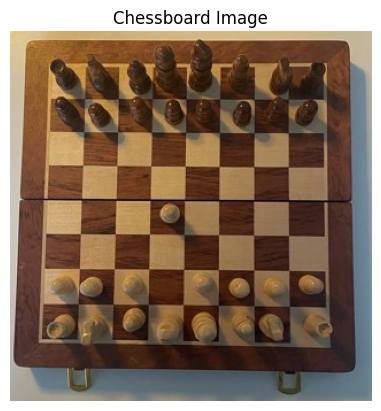

In [40]:
image = 'data/chessboard/chessboard.jpg'
img = cv2.imread(image)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title('Chessboard Image')
plt.axis('off')  # Hide axis
plt.show()

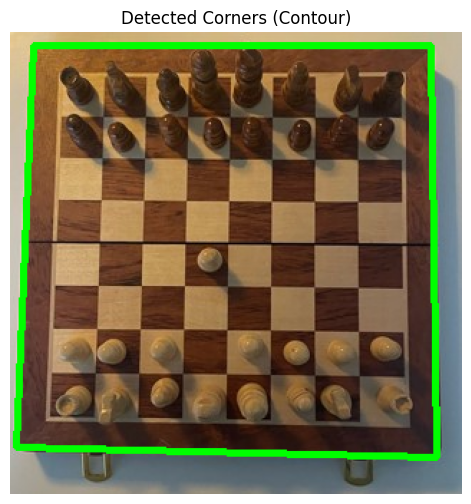

In [41]:
corners = detect_corners(img)
cv2.polylines(img, [np.int32(corners)], isClosed=True, color=(0, 255, 0), thickness=3)
title = "Detected Corners (Contour)"
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(title)
plt.axis("off")
plt.show()